##  Geometric Brownian Motion (GBM)


The price dynamics of an asset under a GBM model follow the stochastic differential equation:

$$
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t
$$

where:

- $S_t$: asset price at time $t$  
- $\mu$: drift (e.g., the risk-free rate $r$ in the Black-Scholes model)  
- $\sigma$: volatility  
- $W_t$: standard Brownian motion


Using a time step $\Delta t$, the discretized version with Euler scheme is:

$$
S_{t+\Delta t} = S_t \cdot \exp\left( \left(\mu - \frac{1}{2}\sigma^2\right)\Delta t + \sigma \sqrt{\Delta t} \cdot Z \right)
$$

where:

- $Z \sim \mathcal{N}(0, 1)$ is an independent random draw at each time step (for each simulated path)

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from models.price_dynamics import generate_trajectories
from products.options import EuropeanOption
from pricers.monte_carlo import monte_carlo_pricer


Let's generate and visualize some trajectories !

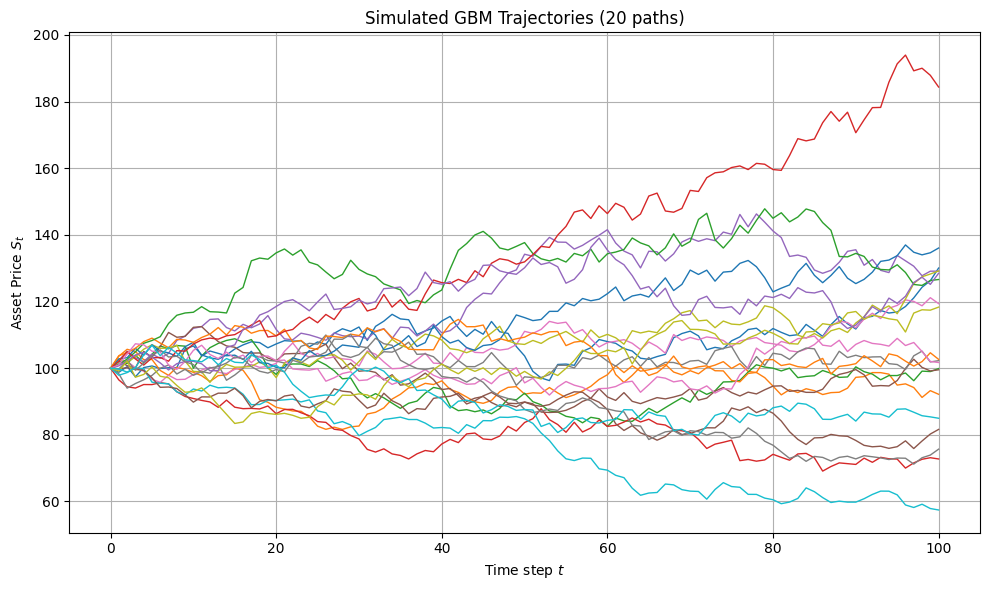

In [74]:
n_paths = 10000
n_steps = 100
r = 0.05
sigma = 0.2
S0 = 100
T = 1

S = generate_trajectories(n_paths, n_steps, r, sigma, S0, T)
plt.figure(figsize=(10, 6))
for i in range(20):  # only 20 paths for clarity
    plt.plot(S[i], lw=1)

plt.title("Simulated GBM Trajectories (20 paths)")
plt.xlabel(r"Time step $t$")
plt.ylabel(r"Asset Price $S_t$")
plt.grid(True)
plt.tight_layout()
plt.show()



Let's check that the trajectories have the right mean and volatility


The simulated price at maturity $T$ follows:

$$
S_T = S_0 \cdot \exp\left( \left( \mu - \frac{1}{2} \sigma^2 \right) T + \sigma \sqrt{T} \cdot Z \right)
$$

We have for the expected price value : $$\mathbb{E}[S_T] = S_0 \cdot e^{\mu T}$$

and for the standard deviation : $$\sigma(S_T) = S_0 \cdot e^{\mu T} \cdot \sqrt{e^{\sigma^2 T} - 1}$$



In [75]:
emp_mean = np.mean(S[:, -1])
emp_std = np.std(S[:, -1])
print(f"Empirical Mean: {emp_mean}")
print(f"Empirical Volatility: {emp_std}")

ST_mean = S0 * np.exp(r * T)
ST_std = S0 * np.exp(r * T) * np.sqrt(np.exp(sigma**2 * T) - 1)

print(f"Theoretical Mean: {ST_mean}")
print(f"Theoretical Volatility: {ST_std}")


print(f"Relative Error in Mean: {np.abs((emp_mean - ST_mean) / ST_mean * 100):.2f}%")
print(f"Relative Error in Volatility: {np.abs((emp_std - ST_std) / ST_std) * 100:.2f}%")


Empirical Mean: 105.1318328724809
Empirical Volatility: 21.237060440667896
Theoretical Mean: 105.12710963760242
Theoretical Volatility: 21.237438824297914
Relative Error in Mean: 0.00%
Relative Error in Volatility: 0.00%


#  European Option Pricing

Recall that the discounted expected payoff of a European call option is  
$C = e^{-rT} \mathbb{E}[(S_T - K)^+]$,  
and for a put option:  
$P = e^{-rT} \mathbb{E}[(K - S_T)^+]$.

We can compute these values using the Monte Carlo method:  
$\hat{C}_{MC} = e^{-rT} \cdot \frac{1}{N} \sum_{i=1}^N \max(S_T^{(i)} - K, 0)$  
$\hat{P}_{MC} = e^{-rT} \cdot \frac{1}{N} \sum_{i=1}^N \max(K - S_T^{(i)}, 0)$

We can compare these with the analytical values from the Black-Scholes model, where the call price is:  
$C = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)$,  
with $d_1 = \frac{\ln(S_0/K) + (r + \frac{1}{2} \sigma^2)T}{\sigma \sqrt{T}}$, and $d_2 = d_1 - \sigma \sqrt{T}$. and \Phi the Cumulative distribution function of the Gaussian Law

Using the put-call parity, we get the price of the European put option:  
$P = C - S_0 + K e^{-rT}$.




In [76]:
K = S0 #ATM

eur_C = EuropeanOption(S0, K=100, r=r, T=T, sigma=sigma, option_type="call")
eur_P = EuropeanOption(S0, K=100, r=r, T=T, sigma=sigma, option_type="put")

C_BS = eur_C.black_scholes_price()
P_BS = eur_P.black_scholes_price()


C_MC = monte_carlo_pricer(eur_C, S)[0]
P_MC = monte_carlo_pricer(eur_P, S)[0]

print(f"Call Price (MC): {C_MC:.4f}")
print(f"Call Price (BS): {C_BS:.4f}")
print(f"Put Price (MC): {P_MC:.4f}")
print(f"Put Price (BS): {P_BS:.4f}")
#relative error :

print(f"Relative Error in Call Price: {np.abs((C_MC - C_BS) / C_BS * 100):.2f}%" )
print(f"Relative Error in Put Price: {np.abs((P_MC - P_BS) / P_BS * 100):.2f}%")

Call Price (MC): 10.4271
Call Price (BS): 10.4506
Put Price (MC): 5.5456
Put Price (BS): 5.5735
Relative Error in Call Price: 0.22%
Relative Error in Put Price: 0.50%


# Exotic Options Pricing

These exotic options do not always have closed-form solutions like the European options, so Monte Carlo methods are often used to approximate their prices.

## 1. Asian Option

- Call payoff: $C = e^{-rT} \mathbb{E}[\max(\bar{S} - K, 0)]$  
  Monte Carlo estimator: $\hat{C} = e^{-rT} \cdot \frac{1}{N} \sum_{i=1}^{N} \max(\bar{S}^{(i)} - K, 0)$

- Put payoff: $P = e^{-rT} \mathbb{E}[\max(K - \bar{S}, 0)]$  
  Monte Carlo estimator: $\hat{P} = e^{-rT} \cdot \frac{1}{N} \sum_{i=1}^{N} \max(K - \bar{S}^{(i)}, 0)$

## 2. Lookback Option

- Lookback call payoff: $C = e^{-rT} \mathbb{E}[\max(S_T - \min S_t, 0)]$  
  Monte Carlo estimator: $\hat{C} = e^{-rT} \cdot \frac{1}{N} \sum_{i=1}^{N} \max(S_T^{(i)} - \min S_t^{(i)}, 0)$

- Lookback put payoff: $P = e^{-rT} \mathbb{E}[\max(\max S_t - S_T, 0)]$  
  Monte Carlo estimator: $\hat{P} = e^{-rT} \cdot \frac{1}{N} \sum_{i=1}^{N} \max(\max S_t^{(i)} - S_T^{(i)}, 0)$

## Monte Carlo Convergence and Variance Analysis

To assess the reliability and efficiency of Monte Carlo pricing, we study the convergence of the estimated option price and the behavior of the standard error as the number of simulations $N$ increases.

Monte Carlo estimators converge at a rate proportional to $1/\sqrt{N}$, where $N$ is the number of simulated paths. This means that to reduce the standard error by a factor of 10, the number of simulations must be increased by a factor of 100.


$$
\text{Standard Error} \approx \frac{C}{\sqrt{N}} \quad \text{where} \quad C = \sigma(\text{discounted payoff})
$$

In practice, we compute an approximation of the constant $C$ by observing the standard error at a fixed number of simulations, say $N_0$. We then define the reference curve as:

$$
\text{C} = \text{Standard Error}(N_0) \times \sqrt{\frac{N_0}{N}}
$$

This allows us to visualize the theoretical $\mathcal{O}(1/\sqrt{N})$ convergence rate alongside the observed error.

The following analysis:

- Computes the estimated option price and its standard error for increasing values of $N$,
- Visualizes the convergence of the price with error bars ($\pm 2 \times$ standard error)


In [77]:
def convergence_and_variance_study(option,N_values, n_steps):

    estimates = []
    errors = []
    for N in N_values:
        paths = generate_trajectories(N, n_steps, option.r, option.sigma, option.S0, option.T)
        mean_price, std_err = monte_carlo_pricer(option, paths)
        estimates.append(mean_price)
        errors.append(std_err)
        print(f"N={N}: Price={mean_price:.4f}, StdErr={std_err:.4f}")

    # Plot Price convergence with error bars
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.errorbar(N_values, estimates, yerr=[2*np.array(errors)], fmt='o-', capsize=5)
    plt.xscale('log')
    plt.xlabel('Number of MC paths (log scale)')
    plt.ylabel('Option Price estimate')
    plt.title(f'Convergence Study - {option.__class__.__name__} ({option.option_type.capitalize()})')

    plt.grid(True)

    # Plot Std Error vs N in log-log scale
    plt.subplot(1,2,2)
    plt.plot(N_values, errors, 'o-', label='Std Error')
    C = errors[0] * np.sqrt(N_values[0])
    plt.plot(N_values, C/np.sqrt(np.array(N_values)), 'r--', label=r'$C/\sqrt{N}$ reference')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of MC paths (log scale)')
    plt.ylabel('Standard Error (log scale)')
    plt.title(f'Variance Behavior - {option.__class__.__name__} ({option.option_type})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


N=100: Price=7.5928, StdErr=1.2241
N=500: Price=10.3681, StdErr=0.6254
N=1000: Price=10.4817, StdErr=0.4577
N=5000: Price=10.1840, StdErr=0.2010
N=10000: Price=10.4536, StdErr=0.1462


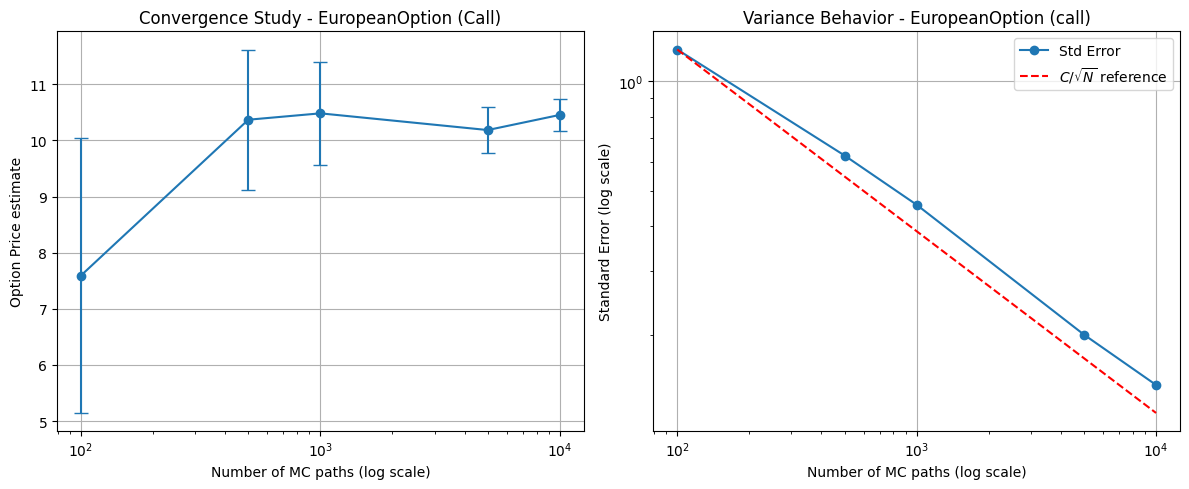

N=100: Price=7.1722, StdErr=0.9127
N=500: Price=6.3493, StdErr=0.3833
N=1000: Price=6.3624, StdErr=0.2631
N=5000: Price=5.7035, StdErr=0.1118
N=10000: Price=5.8697, StdErr=0.0805


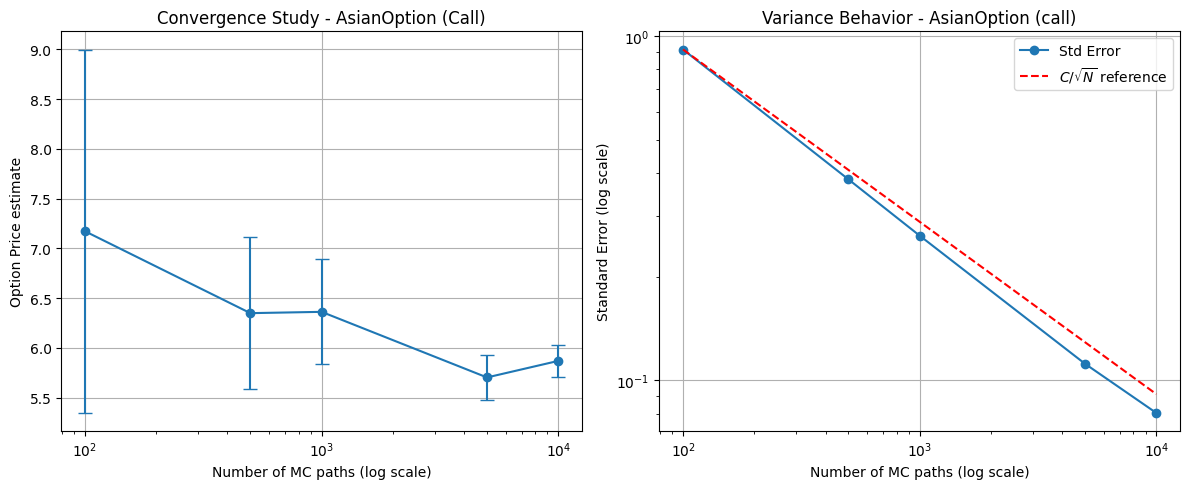

N=100: Price=16.0404, StdErr=1.5236
N=500: Price=14.9247, StdErr=0.6152
N=1000: Price=15.7334, StdErr=0.4481
N=5000: Price=15.9537, StdErr=0.2039
N=10000: Price=15.6090, StdErr=0.1431


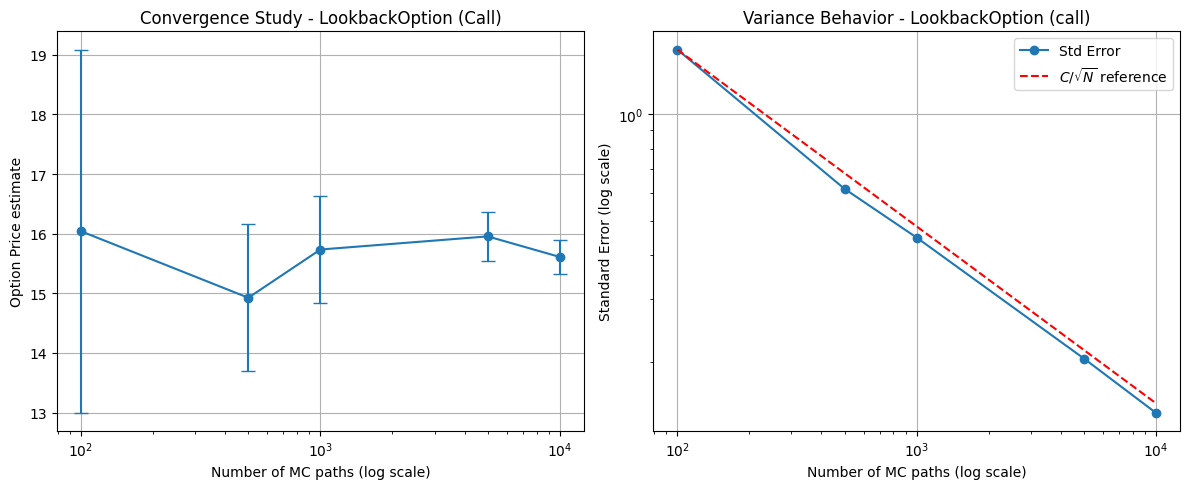

In [78]:
from products.options import AsianOption, LookbackOption


eur_call = EuropeanOption(S0=100, K=100, r=0.05, T=1.0, sigma=0.2, option_type="call")
asian_call = AsianOption(S0=100, K=100, r=0.05, T=1.0, sigma=0.2, option_type="call")
lb_call = LookbackOption(S0=100, K=100, r=0.05, T=1.0, sigma=0.2, option_type="call")

N_values = [100, 500, 1000, 5000, 10000]
n_steps = 50

convergence_and_variance_study(eur_call, N_values=N_values, n_steps=n_steps)
convergence_and_variance_study(asian_call, N_values=N_values, n_steps=n_steps)
convergence_and_variance_study(lb_call, N_values=N_values, n_steps=n_steps)



## Variance Reduction Techniques

Variance reduction methods improve Monte Carlo estimator efficiency by decreasing the variance of the payoff estimator, allowing for more accurate prices with fewer simulated paths.

### Antithetic Variates

This technique generates pairs of negatively correlated paths by simulating one set of random variables $Z$ and its antithetic counterpart $-Z$. The payoff estimator is then averaged over these pairs:

$$
\hat{V}_{\text{anti}} = \frac{1}{2N} \sum_{i=1}^N \left( f(S^{(i)}) + f(\tilde{S}^{(i)}) \right)
$$

where $S^{(i)}$ is the asset path from $Z^{(i)}$, and $\tilde{S}^{(i)}$ is from $-Z^{(i)}$. Averaging these reduces variance by inducing negative correlation.

### Control Variates

This method leverages a control option with a known price $c$ (e.g., a European option) whose payoff $Y$ is correlated with the exotic option payoff $X$. We construct a new estimator:

$$
Z = X - \beta (Y - c)
$$

where

$$
\beta = \frac{\operatorname{Cov}(X, Y)}{\operatorname{Var}(Y)}
$$

This adjusts the exotic payoff by subtracting a scaled difference between the control payoff and its known price, reducing variance due to correlation between $X$ and $Y$.

---

The following analysis:

- Computes and compares the standard error of the price estimates from Standard Monte Carlo, Antithetic Variates, and Control Variates (if a European equivalent is provided)
- Visualizes how each method improves variance reduction as the number of simulated paths increases.


In [79]:
from pricers.monte_carlo import monte_carlo_antithetic
from pricers.monte_carlo import monte_carlo_control_variate

def plot_variance_comparison(option, european_equivalent=None, n_steps=100, max_paths=10000, step=1000):
    np.random.seed(42)
    S0, K, r, T, sigma = option.S0, option.K, option.r, option.T, option.sigma
    mu = r

    path_counts = np.arange(step, max_paths + 1, step)
    stds = []
    stds_anti = []
    stds_cv = []

    for n_paths in path_counts:
        #Standard Monte Carlo
        paths = generate_trajectories(n_paths, n_steps, mu, sigma, S0, T)
        _, std_plain = monte_carlo_pricer(option, paths)
        stds.append(std_plain)

        #  Antithetic Variates 
        paths1, paths2 = generate_trajectories(n_paths, n_steps, mu, sigma, S0, T, antithetic=True)
        _, std_anti = monte_carlo_antithetic(option, paths1, paths2)
        stds_anti.append(std_anti)

        # Control Variates (only for exotic options) 
        if european_equivalent is not None:
            # Same paths used for both options
            paths_cv = generate_trajectories(n_paths, n_steps, mu, sigma, S0, T)
            _, std_cv, _ = monte_carlo_control_variate(option, european_equivalent, paths_cv)
            stds_cv.append(std_cv)
        else:
            stds_cv.append(None)  # Not defined for vanilla options

    plt.figure(figsize=(10, 6))
    ref_std = stds[0] * np.sqrt(path_counts[0]) / np.sqrt(path_counts)  

    # Plotting in log-log scale
    plt.xscale('log')
    plt.yscale('log')

    plt.plot(path_counts, ref_std, label=r'$\frac{C}{\sqrt{N}}$ (Référence)', linestyle='--', color='gray')
    plt.plot(path_counts, stds, label='Standard MC', marker='o')
    plt.plot(path_counts, stds_anti, label='Antithetic Variates', marker='s')
    if european_equivalent is not None:
        plt.plot(path_counts, stds_cv, label='Control Variates', marker='^')

    plt.xlabel('Number of MC Paths (log scale)')
    plt.ylabel('Standard Error (log scale)')
    plt.title(f'Variance Reduction Comparison - {option.__class__.__name__} ({option.option_type})')

    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


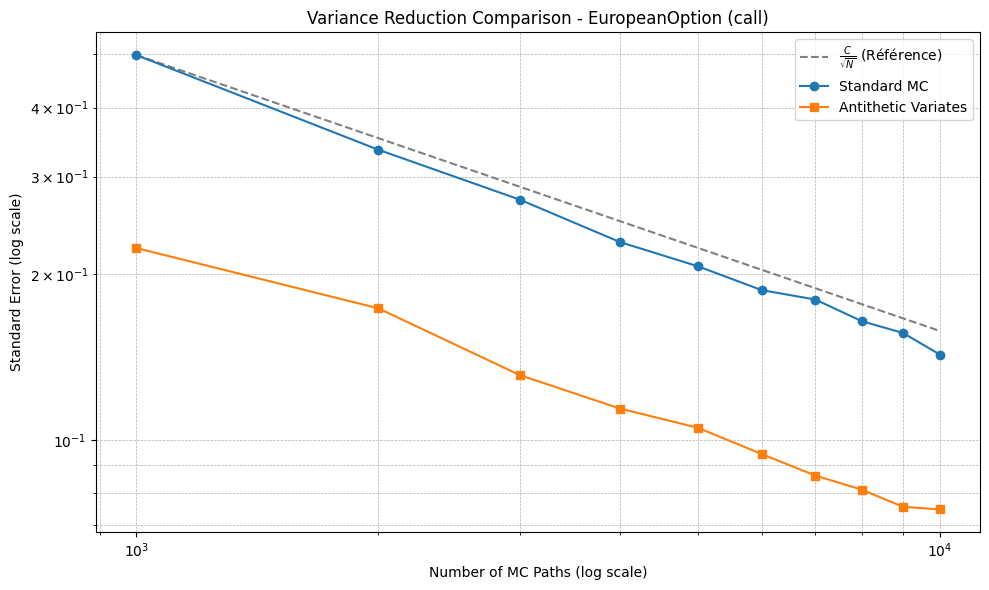

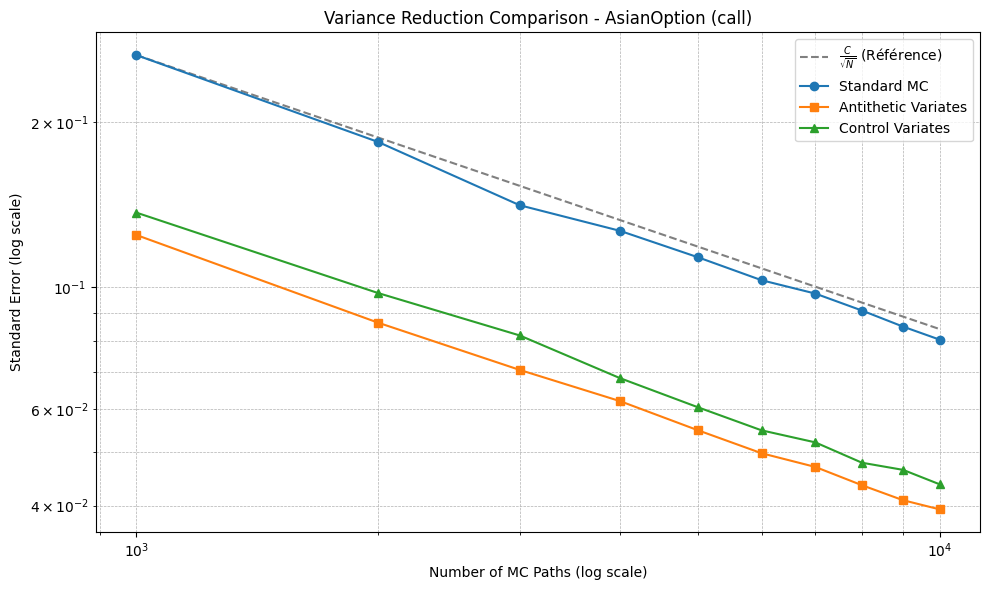

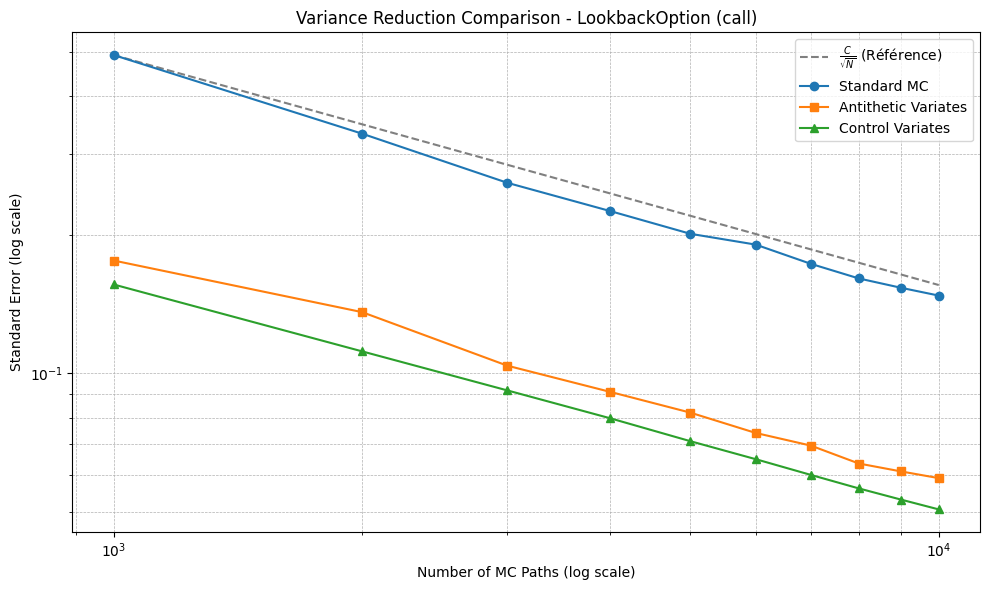

In [80]:

plot_variance_comparison(eur_call)
plot_variance_comparison(asian_call, eur_call)
plot_variance_comparison(lb_call,eur_call)
